### Project - Causal inference
### Hotel Booking Cancellation

#### EDA

In [191]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
df = pd.read_csv('hotel_bookings.csv')
df.shape

(119390, 32)

In [192]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

#### Note ‘Is_repeated_guest’, 'agent' and 'company' are categorical variables.

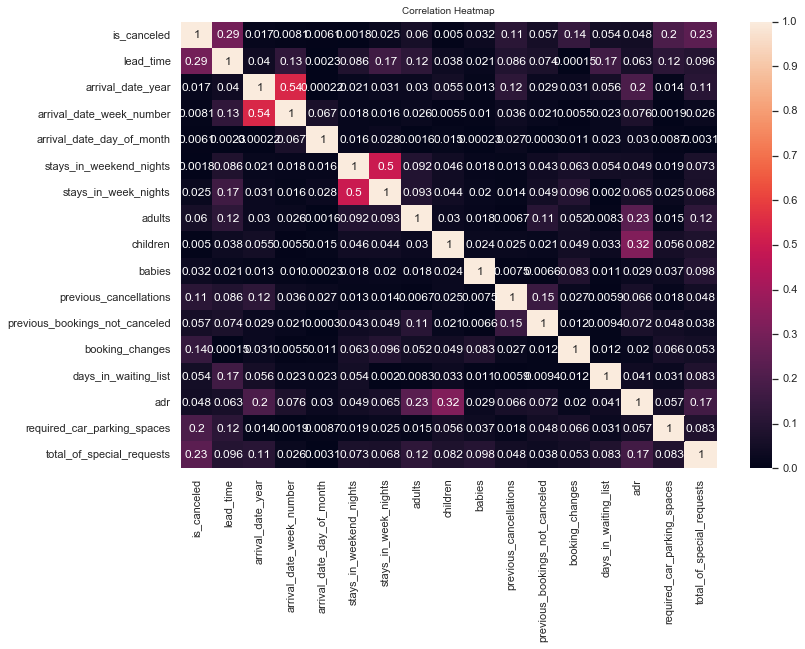

In [173]:
## Increase the size of the heatmap.
plt.figure(figsize=(12, 8))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
df1 = df.drop(['is_repeated_guest','agent','company'], axis=1)
heatmap = sns.heatmap(abs(df1.corr()),vmin=0, vmax=1, annot=True,annot_kws={'size': 12})
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=8);

#### Top three numeric features correlated with 'Is_canceled' are 'lead_time' (0.29), 'total_of_special_requests' (-0.23) and 'required_car_parking_spaces' (-0.2). 

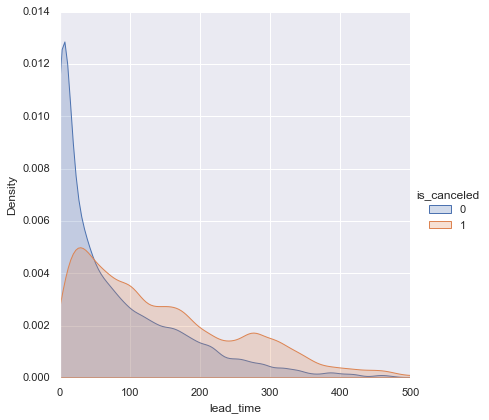

In [174]:
(sns.FacetGrid(df, hue = 'is_canceled',
             height = 6,
             xlim = (0,500))
    .map(sns.kdeplot, 'lead_time', shade = True)
    .add_legend());

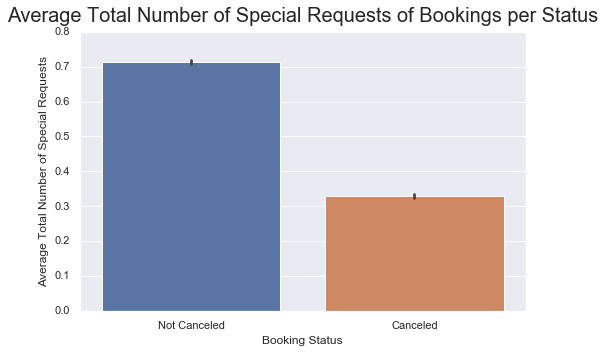

In [175]:
# Visualizing the total number of special requests for canceled and not canceled bookings:
plt.figure(figsize=(8,5)) 
plt.title("Average Total Number of Special Requests of Bookings per Status", fontsize = 20, pad = 10)
sns.barplot(x=df['is_canceled'], y=df['total_of_special_requests'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Total Number of Special Requests", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);


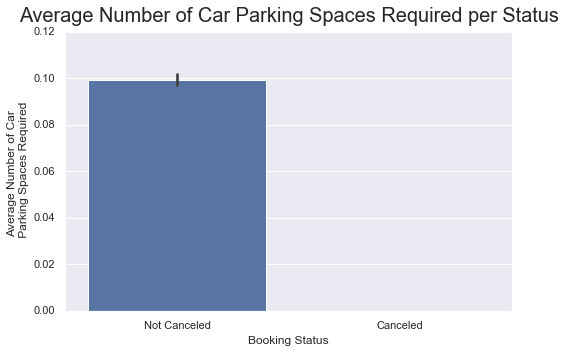

In [176]:
# Visualizing the total number of requested parking spaces for canceled and not canceled bookings:
plt.figure(figsize=(8,5)) 
plt.title("Average Number of Car Parking Spaces Required per Status", fontsize = 20, pad = 10)
sns.barplot(x=df['is_canceled'], y=df['required_car_parking_spaces'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Number of Car \n Parking Spaces Required", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

In [177]:
df['is_canceled']=df['is_canceled'].replace([0,1],["no","yes"])
df['is_repeated_guest'] = df['is_repeated_guest'].replace([0,1],["no","yes"])
#Extracting categorical feature columns
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols=list(set(cols) - set(num_cols))
df_cat=df[cat_cols]
df_cat.columns

Index(['meal', 'market_segment', 'reserved_room_type', 'arrival_date_month',
       'customer_type', 'is_canceled', 'is_repeated_guest', 'deposit_type',
       'reservation_status_date', 'hotel', 'reservation_status',
       'distribution_channel', 'country', 'assigned_room_type'],
      dtype='object')

In [178]:
df['is_canceled'] = df['is_canceled'].astype('category')

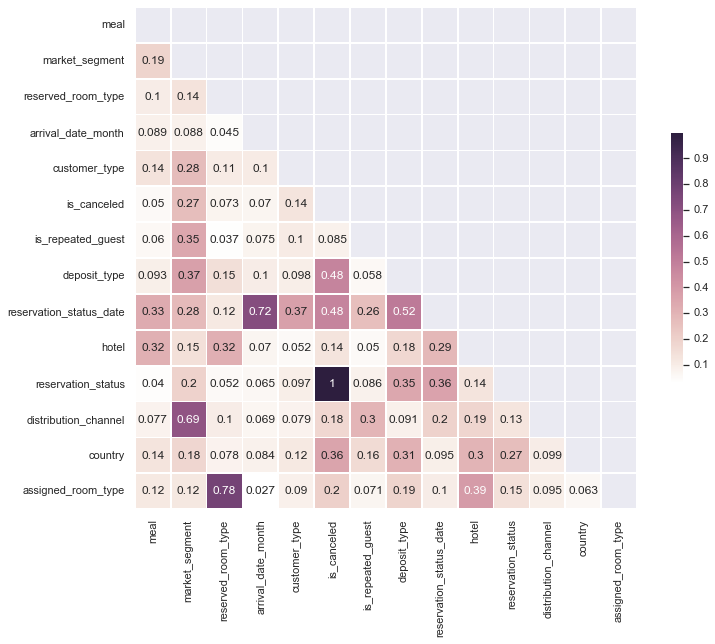

In [179]:
import itertools
import scipy

def cramers_corrected_stat(confusion_matrix):
    """
    Calculates the corrected Cramer's V statistic
    
    Args:
        confusion_matrix: The confusion matrix of the variables to calculate the statistic on
    
    Returns:
        The corrected Cramer's V statistic
    """
    
    #chi2, _, _, _ = scipy.stats.chi2_contingency(confusion_matrix)
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

#Getting the list of columns in the dataframe
cols = list(df_cat.columns.values)

#Creating an empty array to append to as we will go through iteratations to calculate correlations of every combination of variables.
emp_arr = np.zeros((len(cols),len(cols)))

#Iteraiting dataframe using itertools
#itertools.combinations() : Given an array of size n, generate and print all possible combinations of r elements in array.
for col1, col2 in itertools.combinations(cols, 2):
    A, B = df_cat[col1], df_cat[col2]
    idx1, idx2 = cols.index(col1), cols.index(col2)
    conf_mat = pd.crosstab(A,B) 
    #appending results to emp_array
    emp_arr[idx1, idx2] = cramers_corrected_stat(conf_mat.values)
    emp_arr[idx2, idx1] = emp_arr[idx1, idx2]

#creating a correlation matrix
corr = pd.DataFrame(emp_arr, index=cols, columns=cols)

# Mask to get lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

# Draw the heatmap with the mask 
fig = plt.figure(figsize=(12, 9))

sns.heatmap(abs(corr), mask=mask, cmap=cmap, square=True, linewidths=.7,cbar_kws={"shrink": .5}, annot=True,annot_kws={'size': 12})

plt.show()

#### Top three numeric features correlated with 'Is_canceled' are 'reservation_status' (1), 'Is_repeated_guest' (1) and 'country' (0.48), deposit_type (0.48), reservation_status_date (0.48). 

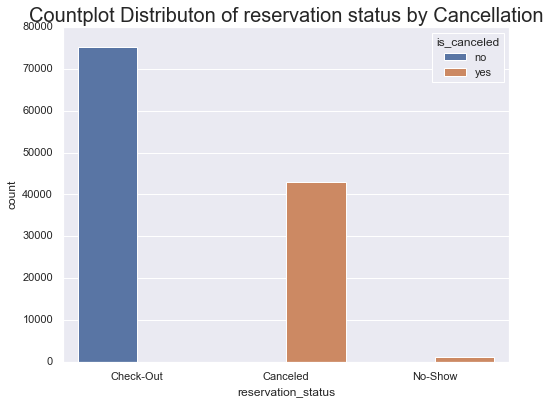

In [180]:
plt.figure(figsize = (8,6))
sns.set(style = "darkgrid")
plt.title("Countplot Distributon of reservation status by Cancellation", fontdict = {'fontsize':20})
ax = sns.countplot(x = "reservation_status", hue = 'is_canceled', data = df)

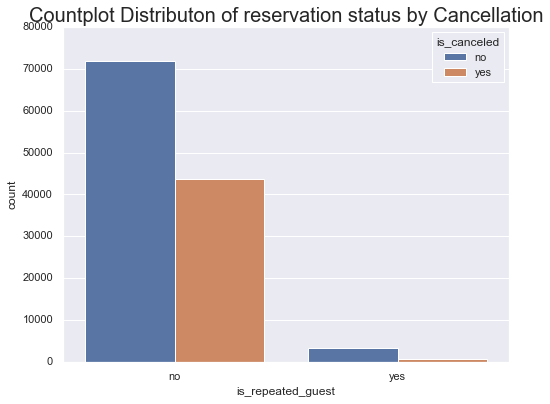

In [181]:
plt.figure(figsize = (8,6))
sns.set(style = "darkgrid")
plt.title("Countplot Distributon of reservation status by Cancellation", fontdict = {'fontsize':20})
ax = sns.countplot(x = "is_repeated_guest", hue = 'is_canceled', data = df)

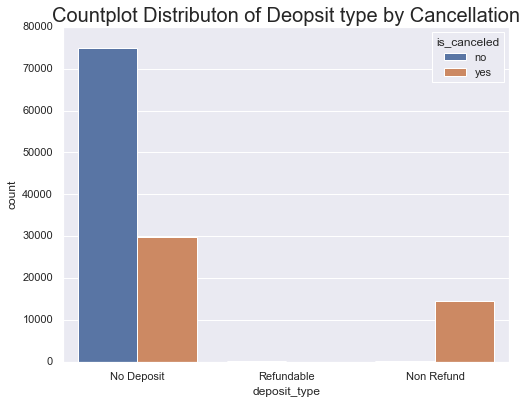

In [182]:
plt.figure(figsize = (8,6))
sns.set(style = "darkgrid")
plt.title("Countplot Distributon of Deopsit type by Cancellation", fontdict = {'fontsize':20})
ax = sns.countplot(x = "deposit_type", hue = 'is_canceled', data = df)

### Data preprocessing

#### -Missing value

In [183]:
na_summary = df.isna().sum()/df.shape[0] *100
na_summary.to_frame(name = "percentage (%)")

,percentage (%)
hotel,0.000000
is_canceled,0.000000
lead_time,0.000000
arrival_date_year,0.000000
arrival_date_month,0.000000
arrival_date_week_number,0.000000
arrival_date_day_of_month,0.000000
stays_in_weekend_nights,0.000000
stays_in_week_nights,0.000000
adults,0.000000


#### I will drop 'company' because the missing percantage is about 95%, which means this feature cann't provide enough information. Addition, it strongly correlated with 'hotel' (0.9) and 'market_segment' (0.82)
#### 'agent' will also be dropped becuase it strongly correlated with 'hotel' (0.95) and 'distribution_channel' (0.82) with 14%  missing percentage. 
#### 'reservation_status' will also be dropped becuase it is repetitive with our target variable.

In [193]:
pd.options.mode.chained_assignment = None
def week_function(feature1, feature2, data_source):
    data_source['weekend_or_weekday'] = 0
    for i in range(0, len(data_source)):
        if feature2.iloc[i] == 0 and feature1.iloc[i] > 0:
            df['weekend_or_weekday'].iloc[i] = 'stay_just_weekend'
        if feature2.iloc[i] > 0 and feature1.iloc[i] == 0:
            df['weekend_or_weekday'].iloc[i] = 'stay_just_weekday'
        if feature2.iloc[i] > 0 and feature1.iloc[i] > 0:
            df['weekend_or_weekday'].iloc[i] = 'stay_both_weekday_and_weekend'
        if feature2.iloc[i] == 0 and feature1.iloc[i] == 0:
            df['weekend_or_weekday'].iloc[i] = 'undefined_data'

            
week_function(df['stays_in_weekend_nights'],df['stays_in_week_nights'], df)

In [194]:
df = df[df.hotel != 'Resort Hotel']
df = df.reset_index(drop=True)

In [195]:
df["company"] = df["company"].astype('category')
df["agent"] = df["agent"].astype('category')
df['is_repeated_guest'] = df['is_repeated_guest'].astype('category')
df['is_canceled'] = df['is_canceled'].astype('category')
df['total_of_special_requests'] = df['total_of_special_requests'].astype('category')
df['days_in_waiting_list'] = df['days_in_waiting_list'].astype('category')

In [196]:
variables_to_drop = ['agent','company','reservation_status','previous_bookings_not_canceled']
df = df.drop(variables_to_drop, axis = 1)

In [197]:
filter = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
df = df[~filter]
df.fillna(0, inplace = True)

### Encode categorical variable

In [198]:
df.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date', 'weekend_or_weekday'],
      dtype='object')

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79163 entries, 0 to 79329
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   is_canceled                  79163 non-null  category
 1   lead_time                    79163 non-null  int64   
 2   arrival_date_year            79163 non-null  int64   
 3   arrival_date_month           79163 non-null  object  
 4   arrival_date_week_number     79163 non-null  int64   
 5   arrival_date_day_of_month    79163 non-null  int64   
 6   stays_in_weekend_nights      79163 non-null  int64   
 7   stays_in_week_nights         79163 non-null  int64   
 8   adults                       79163 non-null  int64   
 9   children                     79163 non-null  float64 
 10  babies                       79163 non-null  int64   
 11  meal                         79163 non-null  object  
 12  country                      79163 non-null  object  
 13  m

In [200]:
# creating numerical and categorical dataframes
cat_cols = [col for col in df.columns if df[col].dtype == 'category' or df[col].dtype == 'O']
cat_cols
cat_df = df[cat_cols]
cat_df

,is_canceled,arrival_date_month,meal,country,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,total_of_special_requests,reservation_status_date,weekend_or_weekday
0,0,July,HB,PRT,Offline TA/TO,TA/TO,0,A,A,No Deposit,0,Transient,0,7/3/15,stay_just_weekday
1,1,July,BB,PRT,Online TA,TA/TO,0,A,A,No Deposit,0,Transient,1,7/1/15,stay_just_weekday
2,1,July,BB,PRT,Online TA,TA/TO,0,A,A,No Deposit,0,Transient,1,4/30/15,stay_just_weekday
3,1,July,BB,PRT,Online TA,TA/TO,0,A,A,No Deposit,0,Transient,2,6/23/15,stay_both_weekday_and_weekend
4,1,July,BB,PRT,Online TA,TA/TO,0,A,A,No Deposit,0,Transient,1,4/2/15,stay_just_weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,August,BB,BEL,Offline TA/TO,TA/TO,0,A,A,No Deposit,0,Transient,0,9/6/17,stay_both_weekday_and_weekend
79326,0,August,BB,FRA,Online TA,TA/TO,0,E,E,No Deposit,0,Transient,2,9/7/17,stay_both_weekday_and_weekend
79327,0,August,BB,DEU,Online TA,TA/TO,0,D,D,No Deposit,0,Transient,4,9/7/17,stay_both_weekday_and_weekend
79328,0,August,BB,GBR,Online TA,TA/TO,0,A,A,No Deposit,0,Transient,0,9/7/17,stay_both_weekday_and_weekend


In [201]:
cat_df['reservation_status_date'] = pd.to_datetime(cat_df['reservation_status_date'])

cat_df['month'] = cat_df['reservation_status_date'].dt.month
cat_df['day'] = cat_df['reservation_status_date'].dt.day
cat_df.drop(['reservation_status_date','arrival_date_month'] , axis = 1, inplace = True)

In [202]:
# printing unique values of each column
for col in cat_df.columns:
    print(f"{col}: \n{cat_df[col].unique()}\n")

is_canceled: 
[0, 1]
Categories (2, int64): [0, 1]

meal: 
['HB' 'BB' 'SC' 'FB']

country: 
['PRT' 'ITA' 'ESP' 'DEU' 'FRA' 'NLD' 'GBR' 'ROU' 'BRA' 'SWE' 'AUT' 'AGO'
 'BEL' 'CHE' 'NOR' 'RUS' 'ISR' 'IRL' 'POL' 'CHN' 'USA' 'MAR' 'AUS' 'MOZ'
 'TUN' 'DNK' 'MEX' 'GRC' 'DZA' 'COL' 'LUX' 'CN' 'LVA' 'FIN' 'HRV' 'STP'
 'BGR' 'UKR' 'VEN' 'TWN' 'IRN' 'KOR' 'TUR' 'BLR' 'JPN' 'CZE' 'HUN' 'AZE'
 'KAZ' 'IND' 'NZL' 'IDN' 'LTU' 'LBN' 'SRB' 'SVN' 'SVK' 'MYS' 'CMR' 'CHL'
 'ARG' 0 'SGP' 'SEN' 'PER' 'EGY' 'SAU' 'KNA' 'JOR' 'ZAF' 'THA' 'KWT' 'LKA'
 'ALB' 'ETH' 'PHL' 'ARE' 'ECU' 'OMN' 'IRQ' 'AND' 'CPV' 'MUS' 'HND' 'NGA'
 'RWA' 'EST' 'PAK' 'GEO' 'GIB' 'ZMB' 'QAT' 'KHM' 'HKG' 'MCO' 'BGD' 'ISL'
 'UZB' 'URY' 'IMN' 'TJK' 'ARM' 'MDV' 'NIC' 'GGY' 'BEN' 'MAC' 'CYP' 'VGB'
 'MLT' 'CRI' 'TZA' 'JEY' 'GAB' 'MKD' 'BIH' 'VNM' 'GHA' 'TMP' 'GLP' 'KEN'
 'PRI' 'DOM' 'LIE' 'GNB' 'BHR' 'MNE' 'UMI' 'MYT' 'FRO' 'CIV' 'ZWE' 'MMR'
 'PAN' 'BFA' 'LBY' 'MLI' 'NAM' 'BOL' 'JAM' 'SYC' 'PRY' 'BRB' 'ABW' 'AIA'
 'SLV' 'DMA' 'CUB' 'PYF' 'UGA' 

In [203]:
a = []
for i in cat_df['meal']:
    if i =='SC' or 'undefined':
        y_1 = 'no_food'
    else:
        y_1 = 'have_food'
    a.append(y_1)
cat_df['meal'] = a

y = []
for i in cat_df['country']:
    if i =='PRT' or i=='DEU' or i=='FRA' or i=='ESP':
        y_1 = 'w-europe'
    else:
        y_1 = 'else2'
    y.append(y_1)
cat_df['country'] = y

z = []
for i in cat_df['customer_type']:
    if i =='Transient':
        y_1 = 'Transient'
    else:
        y_1 = 'else3'
    z.append(y_1)
cat_df['customer_type'] = z

a = []
for i in cat_df['reserved_room_type']:
    if i =='A':
        y_1 = 'A'
    else:
        y_1 = 'else4'
    a.append(y_1)
cat_df['reserved_room_type'] = a

a = []
for i in cat_df['assigned_room_type']:
    if i =='A':
        y_1 = 'A'
    else:
        y_1 = 'else5'
    a.append(y_1)
cat_df['assigned_room_type'] = a

a = []
for i in cat_df['month']:
    if i == 4 or 5 or 6 or 7 or 8 or 9:
        y_1 = 'popular'
    else:
        y_1 = 'non-popular'
    a.append(y_1)
cat_df['month'] = a

a = []
for i in cat_df['day']:
    if i == range(15):
        y_1 = 'upper'
    else:
        y_1 = 'lower'
    a.append(y_1)
cat_df['day'] = a

a = []
for i in cat_df['days_in_waiting_list']:
    if i ==0:
        y_1 = 'no_wait_list'
    else:
        y_1 = 'on_wait_list'
    a.append(y_1)
cat_df['days_in_waiting_list'] = a

a = []
for i in cat_df['total_of_special_requests']:
    if i == 0:
        y_1 = 'no'
    else:
        y_1 = 'yes'
    a.append(y_1)
cat_df['total_of_special_requests'] = a

a = []
for i in cat_df['distribution_channel']:
    if i == 'TA/TO':
        y_1 = 'TA/TO'
    else:
        y_1 = 'Else1'
    a.append(y_1)
cat_df['distribution_channel'] = a

a = []
for i in cat_df['deposit_type']:
    if i == 'No Deposit' or 'Refundable':
        y_1 = 'no_cost_to_cancel'
    else:
        y_1 = 'non-refund'
    a.append(y_1)
cat_df['deposit_type'] = a
z = []
for i in cat_df['market_segment']:
    if i =='Online TA':
        y_1 = 'online'
    else:
        y_1 = 'offline'
    z.append(y_1)
cat_df['market_segment'] = z

In [204]:
cat_df

,is_canceled,meal,country,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,total_of_special_requests,weekend_or_weekday,month,day
0,0,no_food,w-europe,offline,TA/TO,0,A,A,no_cost_to_cancel,no_wait_list,Transient,no,stay_just_weekday,popular,lower
1,1,no_food,w-europe,online,TA/TO,0,A,A,no_cost_to_cancel,no_wait_list,Transient,yes,stay_just_weekday,popular,lower
2,1,no_food,w-europe,online,TA/TO,0,A,A,no_cost_to_cancel,no_wait_list,Transient,yes,stay_just_weekday,popular,lower
3,1,no_food,w-europe,online,TA/TO,0,A,A,no_cost_to_cancel,no_wait_list,Transient,yes,stay_both_weekday_and_weekend,popular,lower
4,1,no_food,w-europe,online,TA/TO,0,A,A,no_cost_to_cancel,no_wait_list,Transient,yes,stay_just_weekday,popular,lower
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,no_food,else2,offline,TA/TO,0,A,A,no_cost_to_cancel,no_wait_list,Transient,no,stay_both_weekday_and_weekend,popular,lower
79326,0,no_food,w-europe,online,TA/TO,0,else4,else5,no_cost_to_cancel,no_wait_list,Transient,yes,stay_both_weekday_and_weekend,popular,lower
79327,0,no_food,w-europe,online,TA/TO,0,else4,else5,no_cost_to_cancel,no_wait_list,Transient,yes,stay_both_weekday_and_weekend,popular,lower
79328,0,no_food,else2,online,TA/TO,0,A,A,no_cost_to_cancel,no_wait_list,Transient,no,stay_both_weekday_and_weekend,popular,lower


In [205]:
cat_df.columns

Index(['is_canceled', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'reserved_room_type',
       'assigned_room_type', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'total_of_special_requests', 'weekend_or_weekday',
       'month', 'day'],
      dtype='object')

In [206]:
onehotcol= ['meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'reserved_room_type',
       'assigned_room_type', 'deposit_type', 'days_in_waiting_list',
       'customer_type', 'total_of_special_requests', 'weekend_or_weekday',
       'month', 'day']
df_categotical = cat_df[onehotcol]
df_model_dummy = pd.get_dummies(cat_df, columns = onehotcol, prefix = onehotcol, drop_first=True)
df_model_dummy

,is_canceled,country_w-europe,market_segment_online,distribution_channel_TA/TO,is_repeated_guest_1,reserved_room_type_else4,assigned_room_type_else5,days_in_waiting_list_on_wait_list,customer_type_else3,total_of_special_requests_yes,weekend_or_weekday_stay_just_weekday,weekend_or_weekday_stay_just_weekend,weekend_or_weekday_undefined_data
0,0,1,0,1,0,0,0,0,0,0,1,0,0
1,1,1,1,1,0,0,0,0,0,1,1,0,0
2,1,1,1,1,0,0,0,0,0,1,1,0,0
3,1,1,1,1,0,0,0,0,0,1,0,0,0
4,1,1,1,1,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,0,0,1,0,0,0,0,0,0,0,0,0
79326,0,1,1,1,0,1,1,0,0,1,0,0,0
79327,0,1,1,1,0,1,1,0,0,1,0,0,0
79328,0,0,1,1,0,0,0,0,0,0,0,0,0


In [207]:
num_df = df.drop(columns = cat_cols, axis = 1)

In [208]:
num_df = df.drop(columns = cat_cols, axis = 1)
def family(data):
    if ((data['adults'] > 0) & (data['children'] > 0)):
        val = 1
    elif ((data['adults'] > 0) & (data['babies'] > 0)):
        val = 1
    else:
        val = 0
    return val

In [209]:
df_model_dummy["is_family"]= num_df.apply(family, axis = 1)
num_df["total_customer"] = num_df["adults"] + num_df["children"] + num_df["babies"]

### Standardize numeric variables

In [210]:
num_df.drop(['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','adults', 'babies', 'children','stays_in_weekend_nights','stays_in_week_nights'], axis = 1, inplace = True)
num_df = num_df.reset_index(drop=True)
num_df

,lead_time,previous_cancellations,booking_changes,adr,required_car_parking_spaces,total_customer
0,6,0,0,0.00,0,1.0
1,88,0,0,76.50,0,2.0
2,65,0,0,68.00,0,1.0
3,92,0,0,76.50,0,2.0
4,100,0,0,76.50,0,2.0
...,...,...,...,...,...,...
79158,23,0,0,96.14,0,2.0
79159,102,0,0,225.43,0,3.0
79160,34,0,0,157.71,0,2.0
79161,109,0,0,104.40,0,2.0


In [211]:
num_df['adr'] = num_df['adr'].fillna(value = num_df['adr'].mean())
num_df['adr'] =num_df['adr'].replace(0,num_df['adr'].mean())

num_df.head()

,lead_time,previous_cancellations,booking_changes,adr,required_car_parking_spaces,total_customer
0,6,0,0,105.503191,0,1.0
1,88,0,0,76.500000,0,2.0
2,65,0,0,68.000000,0,1.0
3,92,0,0,76.500000,0,2.0
4,100,0,0,76.500000,0,2.0


In [212]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
num_df_scaled = scaler.fit_transform(num_df)
num_df_scaled = pd.DataFrame(num_df_scaled,columns=num_df.columns)
num_df_scaled

,lead_time,previous_cancellations,booking_changes,adr,required_car_parking_spaces,total_customer
0,-0.936195,-0.192001,-0.313518,-0.034301,-0.157203,-1.507768
1,-0.197218,-0.192001,-0.313518,-0.731291,-0.157203,0.077035
2,-0.404492,-0.192001,-0.313518,-0.935558,-0.157203,-1.507768
3,-0.161170,-0.192001,-0.313518,-0.731291,-0.157203,0.077035
4,-0.089074,-0.192001,-0.313518,-0.731291,-0.157203,0.077035
...,...,...,...,...,...,...
79158,-0.782993,-0.192001,-0.313518,-0.259313,-0.157203,0.077035
79159,-0.071051,-0.192001,-0.313518,2.847715,-0.157203,1.661838
79160,-0.683861,-0.192001,-0.313518,1.220304,-0.157203,0.077035
79161,-0.007967,-0.192001,-0.313518,-0.060813,-0.157203,0.077035


In [213]:
num_df_scaled.var()

lead_time                      1.000013
previous_cancellations         1.000013
booking_changes                1.000013
adr                            1.000013
required_car_parking_spaces    1.000013
total_customer                 1.000013
dtype: float64

In [214]:
data_1 = pd.merge(df_model_dummy, num_df_scaled, left_index=True, right_index=True)
data_1= data_1.reset_index(drop=True)

In [215]:
# data_1.to_csv (r'C:\Users\Ron\Desktop\liba\project\cleaned_data', header=True,index = False)

### Causal inference

### Hypothesis : Cancellation rate will increase when lead_time greater than 190 days. 

#### Outcome variable: is_canceled ; Treatment variable: lead_time; Control variable: the rest 

In [216]:
import statistics
statistics.mean(num_df['lead_time']), statistics.stdev(num_df['lead_time'])
(190 - statistics.mean(num_df['lead_time']))/ statistics.stdev(num_df['lead_time'])

0.7219942663784161

### Hypothesis : People tend to cancel their booking researvations when lead_time greater than 0.7219942663784161 hours. 

- Step 1: use control variable to predict treatment varibale

In [217]:
x = data_1.drop(['is_canceled','lead_time'], axis=1) # control
Y = data_1['is_canceled']
T = np.repeat(0, data_1.shape[0])

for i in range(data_1.shape[0]):
    if data_1['lead_time'][i] > 0.7219942663784161: 
        T[i] = 1 
    else:
        T[i] = 0
sum(T==1),sum(T==0)

(15601, 63395)

In [218]:
trt = pd.DataFrame(data=T, columns = ['treatment'])
full_data_before = pd.concat([x, trt], axis = 1)
full_data_before

,country_w-europe,market_segment_online,distribution_channel_TA/TO,is_repeated_guest_1,reserved_room_type_else4,assigned_room_type_else5,days_in_waiting_list_on_wait_list,customer_type_else3,total_of_special_requests_yes,weekend_or_weekday_stay_just_weekday,weekend_or_weekday_stay_just_weekend,weekend_or_weekday_undefined_data,is_family,previous_cancellations,booking_changes,adr,required_car_parking_spaces,total_customer,treatment
0,1,0,1,0,0,0,0,0,0,1,0,0,0,-0.192001,-0.313518,-0.034301,-0.157203,-1.507768,0
1,1,1,1,0,0,0,0,0,1,1,0,0,0,-0.192001,-0.313518,-0.731291,-0.157203,0.077035,0
2,1,1,1,0,0,0,0,0,1,1,0,0,0,-0.192001,-0.313518,-0.935558,-0.157203,-1.507768,0
3,1,1,1,0,0,0,0,0,1,0,0,0,0,-0.192001,-0.313518,-0.731291,-0.157203,0.077035,0
4,1,1,1,0,0,0,0,0,1,1,0,0,0,-0.192001,-0.313518,-0.731291,-0.157203,0.077035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78991,1,0,1,0,0,0,0,1,0,0,0,0,0,-0.192001,-0.313518,-0.259313,-0.157203,0.077035,0
78992,1,0,1,0,0,0,0,1,0,0,0,0,0,-0.192001,-0.313518,2.847715,-0.157203,1.661838,0
78993,0,1,1,0,0,0,0,0,1,1,0,0,0,-0.192001,-0.313518,1.220304,-0.157203,0.077035,0
78994,1,0,1,0,0,0,0,1,0,0,0,0,0,-0.192001,-0.313518,-0.060813,-0.157203,0.077035,0


In [219]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
model1 = LogisticRegression(solver='liblinear', random_state=0).fit(x, T)
y1 = model1.predict(x)
model1.predict_proba(x)

array([[0.82894631, 0.17105369],
       [0.7464677 , 0.2535323 ],
       [0.82068257, 0.17931743],
       ...,
       [0.92358216, 0.07641784],
       [0.79214861, 0.20785139],
       [0.89670786, 0.10329214]])

In [220]:
predictions = model1.predict_proba(x)
predictions_binary = model1.predict(x)
from sklearn import metrics
print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))
print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(T, predictions_binary)))
print('F1 score is: {:.4f}'.format(metrics.f1_score(T, predictions_binary)))
from sklearn.linear_model import LogisticRegression as lr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import pandas as pd
# import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)
from scipy.special import logit
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])
df1 = pd.DataFrame(predictions[:,1], columns= ['propensity'])
df2 = pd.DataFrame(T, columns= ['T'])
df3 = pd.concat([df1, df2], axis = 1)
df4 = pd.DataFrame(predictions_logit,columns= ['logit(propensity)'])
df5 = pd.concat([df4, df2], axis = 1)

Accuracy: 0.8207

Confusion matrix:
[[62686   709]
 [13457  2144]]

F1 score is: 0.2324


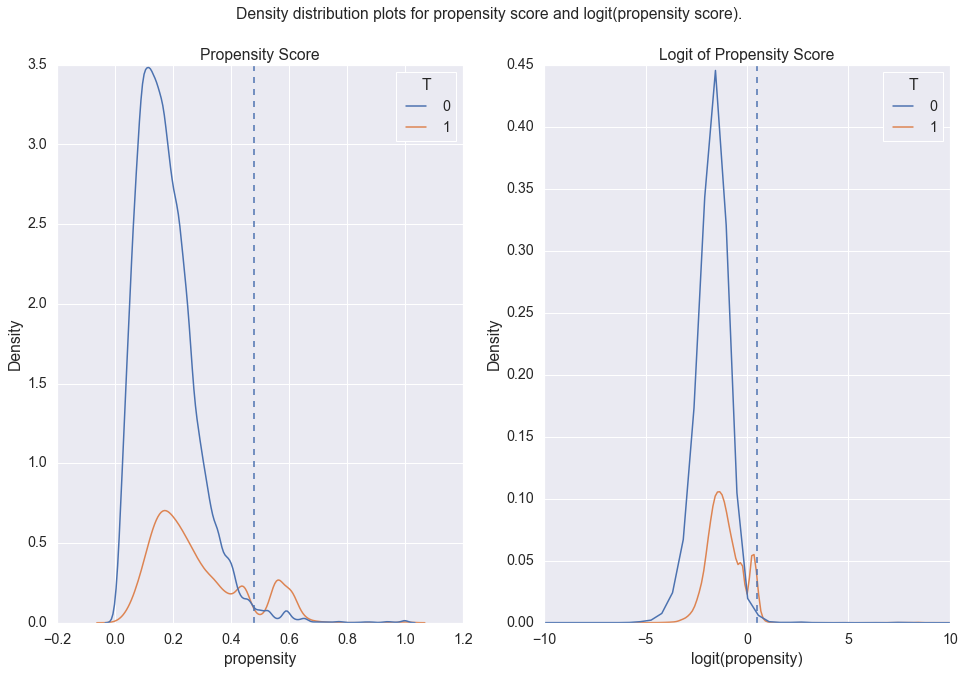

In [221]:
fig, ax = plt.subplots(1,2)
fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
sns.kdeplot(data = df3, x = df3['propensity'],hue = df3['T'] , ax = ax[0])
ax[0].set_title('Propensity Score')
ax[0].axvline(0.48, ls='--')
sns.kdeplot(data = df5, x = df5['logit(propensity)'],hue = df5['T'] ,  ax = ax[1])
ax[1].axvline(0.48, ls='--')
ax[1].set_xlim([-10, 10])
ax[1].set_title('Logit of Propensity Score')
plt.show()

In [222]:
df_data= full_data_before
df_data.loc[:,'propensity_score'] = predictions[:,1]
df_data.loc[:,'propensity_score_logit'] = predictions_logit
df_data.loc[:,'outcome'] = Y
df_data.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
df_data.dropna(inplace=True)
  
# Printing df
df_data = df_data.reset_index(drop=True)
df_data

,country_w-europe,market_segment_online,distribution_channel_TA/TO,is_repeated_guest_1,reserved_room_type_else4,assigned_room_type_else5,days_in_waiting_list_on_wait_list,customer_type_else3,total_of_special_requests_yes,weekend_or_weekday_stay_just_weekday,...,is_family,previous_cancellations,booking_changes,adr,required_car_parking_spaces,total_customer,treatment,propensity_score,propensity_score_logit,outcome
0,1,0,1,0,0,0,0,0,0,1,...,0,-0.192001,-0.313518,-0.034301,-0.157203,-1.507768,0,0.171054,-1.578178,0
1,1,1,1,0,0,0,0,0,1,1,...,0,-0.192001,-0.313518,-0.731291,-0.157203,0.077035,0,0.253532,-1.079861,1
2,1,1,1,0,0,0,0,0,1,1,...,0,-0.192001,-0.313518,-0.935558,-0.157203,-1.507768,0,0.179317,-1.520979,1
3,1,1,1,0,0,0,0,0,1,0,...,0,-0.192001,-0.313518,-0.731291,-0.157203,0.077035,0,0.215227,-1.293704,1
4,1,1,1,0,0,0,0,0,1,1,...,0,-0.192001,-0.313518,-0.731291,-0.157203,0.077035,0,0.253532,-1.079861,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78991,1,0,1,0,0,0,0,1,0,0,...,0,-0.192001,-0.313518,-0.259313,-0.157203,0.077035,0,0.232789,-1.192627,0
78992,1,0,1,0,0,0,0,1,0,0,...,0,-0.192001,-0.313518,2.847715,-0.157203,1.661838,0,0.053338,-2.876286,0
78993,0,1,1,0,0,0,0,0,1,1,...,0,-0.192001,-0.313518,1.220304,-0.157203,0.077035,0,0.076418,-2.492044,0
78994,1,0,1,0,0,0,0,1,0,0,...,0,-0.192001,-0.313518,-0.060813,-0.157203,0.077035,0,0.207851,-1.337926,0


In [223]:
caliper = np.std(df_data.propensity_score) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(df_data[['propensity_score_logit']].to_numpy())
# Common support distances and indexes
distances , indexes = knn.kneighbors(
    df_data[['propensity_score_logit']].to_numpy(), \
    n_neighbors=10)
print('For item 0, the 4 closest distances are (first item is self):')
for ds in distances[0,0:4]:
    print('Element distance: {:4f}'.format(ds))
print('...')
print('For item 0, the 4 closest indexes are (first item is self):')
for idx in indexes[0,0:4]:
    print('Element index: {}'.format(idx))
print('...')


Caliper (radius) is: 0.0309

For item 0, the 4 closest distances are (first item is self):
Element distance: 0.000000
Element distance: 0.000000
Element distance: 0.000000
Element distance: 0.000000
...
For item 0, the 4 closest indexes are (first item is self):
Element index: 36187
Element index: 9013
Element index: 23122
Element index: 45549
...


- Step 2: matching propensity score

In [224]:
def perfom_matching_v2(row, indexes, df_data):
    current_index = int(row['index']) # Obtain value from index-named column, not the actual DF index.
    prop_score_logit = row['propensity_score_logit']
    for idx in indexes[current_index,:]:
        if (current_index != idx) and (row.treatment == 1) and (df_data.loc[idx].treatment == 0):
            return int(idx)
         
df_data['matched_element'] = df_data.reset_index().apply(perfom_matching_v2, axis = 1, args = (indexes, df_data))


In [225]:
treated_with_match = ~df_data.matched_element.isna()
treated_matched_data = df_data[treated_with_match][df_data.columns]
treated_matched_data.head(3)

,country_w-europe,market_segment_online,distribution_channel_TA/TO,is_repeated_guest_1,reserved_room_type_else4,assigned_room_type_else5,days_in_waiting_list_on_wait_list,customer_type_else3,total_of_special_requests_yes,weekend_or_weekday_stay_just_weekday,...,previous_cancellations,booking_changes,adr,required_car_parking_spaces,total_customer,treatment,propensity_score,propensity_score_logit,outcome,matched_element
3750,1,0,1,0,0,1,0,1,0,0,...,-0.192001,-0.313518,-0.118488,-0.157203,0.077035,1,0.118574,-2.006008,0,41195.0
3751,0,0,1,0,0,1,0,1,1,0,...,-0.192001,-0.313518,-0.118488,-0.157203,0.077035,1,0.101709,-2.178380,0,48732.0
3763,1,0,1,0,0,0,0,0,0,0,...,-0.192001,-0.313518,-0.118488,-0.157203,0.077035,1,0.242365,-1.139759,1,23760.0


In [226]:
treated_matched_data['matched_element']=treated_matched_data['matched_element'].astype(int)
treated_matched_data.head(3)

,country_w-europe,market_segment_online,distribution_channel_TA/TO,is_repeated_guest_1,reserved_room_type_else4,assigned_room_type_else5,days_in_waiting_list_on_wait_list,customer_type_else3,total_of_special_requests_yes,weekend_or_weekday_stay_just_weekday,...,previous_cancellations,booking_changes,adr,required_car_parking_spaces,total_customer,treatment,propensity_score,propensity_score_logit,outcome,matched_element
3750,1,0,1,0,0,1,0,1,0,0,...,-0.192001,-0.313518,-0.118488,-0.157203,0.077035,1,0.118574,-2.006008,0,41195
3751,0,0,1,0,0,1,0,1,1,0,...,-0.192001,-0.313518,-0.118488,-0.157203,0.077035,1,0.101709,-2.178380,0,48732
3763,1,0,1,0,0,0,0,0,0,0,...,-0.192001,-0.313518,-0.118488,-0.157203,0.077035,1,0.242365,-1.139759,1,23760


In [227]:
def obtain_match_details(row, all_data, attribute):
    return all_data.loc[row.matched_element][attribute]

untreated_matched_data = pd.DataFrame(data = treated_matched_data.matched_element)

attributes = df_data.columns[:-1]
for attr in attributes:
    untreated_matched_data[attr] = untreated_matched_data.apply(obtain_match_details, axis = 1, all_data = df_data, attribute = attr)
    
untreated_matched_data = untreated_matched_data.set_index('matched_element')

In [228]:
untreated_matched_data.head(4)

,country_w-europe,market_segment_online,distribution_channel_TA/TO,is_repeated_guest_1,reserved_room_type_else4,assigned_room_type_else5,days_in_waiting_list_on_wait_list,customer_type_else3,total_of_special_requests_yes,weekend_or_weekday_stay_just_weekday,...,is_family,previous_cancellations,booking_changes,adr,required_car_parking_spaces,total_customer,treatment,propensity_score,propensity_score_logit,outcome
matched_element,,,,,,,,,,,,,,,,,,,,,
41195,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,-0.192001,-0.313518,-0.118488,-0.157203,0.077035,0.0,0.118574,-2.006008,0.0
48732,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-0.192001,-0.313518,0.220355,-0.157203,-1.507768,0.0,0.101710,-2.178363,0.0
23760,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.192001,-0.313518,-0.118488,-0.157203,0.077035,0.0,0.242365,-1.139759,1.0
39047,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,2.213341,1.390267,1.258515,-0.157203,3.246641,0.0,0.578696,0.317421,0.0


In [229]:
all_mached_data = pd.concat([treated_matched_data, untreated_matched_data])
all_mached_data

,country_w-europe,market_segment_online,distribution_channel_TA/TO,is_repeated_guest_1,reserved_room_type_else4,assigned_room_type_else5,days_in_waiting_list_on_wait_list,customer_type_else3,total_of_special_requests_yes,weekend_or_weekday_stay_just_weekday,...,previous_cancellations,booking_changes,adr,required_car_parking_spaces,total_customer,treatment,propensity_score,propensity_score_logit,outcome,matched_element
3750,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-0.192001,-0.313518,-0.118488,-0.157203,0.077035,1.0,0.118574,-2.006008,0.0,41195.0
3751,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,-0.192001,-0.313518,-0.118488,-0.157203,0.077035,1.0,0.101709,-2.178380,0.0,48732.0
3763,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.192001,-0.313518,-0.118488,-0.157203,0.077035,1.0,0.242365,-1.139759,1.0,23760.0
3775,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.192001,-0.313518,-2.109495,-0.157203,0.077035,1.0,0.578746,0.317628,1.0,39047.0
3776,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.192001,-0.313518,-2.109495,-0.157203,0.077035,1.0,0.578746,0.317628,1.0,39047.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43161,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.192001,-0.313518,-0.034301,-0.157203,-1.507768,0.0,0.120050,-1.991958,0.0,NaN
25279,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.192001,-0.313518,0.241984,-0.157203,0.077035,0.0,0.173709,-1.559568,1.0,NaN
59698,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.192001,-0.313518,-0.515007,-0.157203,0.077035,0.0,0.267869,-1.005462,0.0,NaN
37867,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.192001,-0.313518,-0.460216,-0.157203,0.077035,0.0,0.263237,-1.029213,0.0,NaN


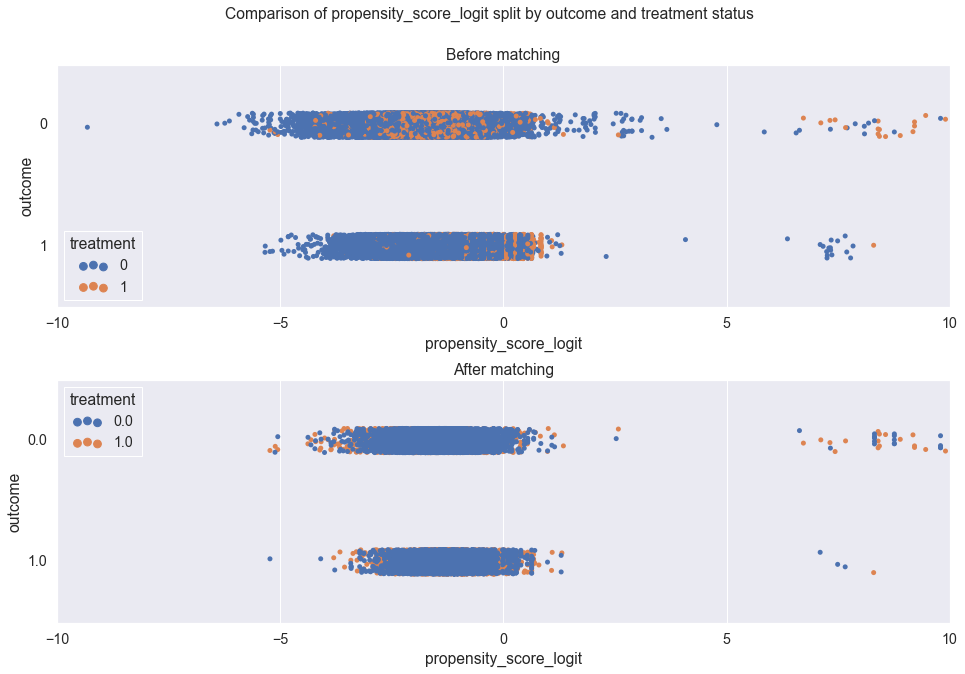

In [230]:
fig, ax = plt.subplots(2,1)
fig.suptitle('Comparison of {} split by outcome and treatment status'.format('propensity_score_logit'))
sns.stripplot(data = df_data, y = 'outcome', x = 'propensity_score_logit', hue = 'treatment', orient = 'h', ax = ax[0]).set(title = 'Before matching', xlim=(-10, 10))
sns.stripplot(data = all_mached_data, y = 'outcome', x = 'propensity_score_logit', hue = 'treatment', ax = ax[1] , orient = 'h').set(title = 'After matching', xlim=(-10, 10))
plt.subplots_adjust(hspace = 0.3)
plt.show()
fig.savefig("jitter_plot.png")

In [243]:
statistics.mean(all_mached_data['outcome'][all_mached_data['treatment']==1]) - statistics.mean(all_mached_data['outcome'][all_mached_data['treatment']==0]) 

0.15137126483831348

In [242]:
from sklearn.utils import resample
y=[]
for i in range(100):
    x1, y1 = resample(all_mached_data['outcome'][all_mached_data['treatment']==1], all_mached_data['outcome'][all_mached_data['treatment']==0], replace=True)
    ate = np.mean(x1) - np.mean(y1)
    y.append(ate)
min(y),max(y)

(0.13933688088415885, 0.16545231273024963)

- Step 3: Uncertainty qualification

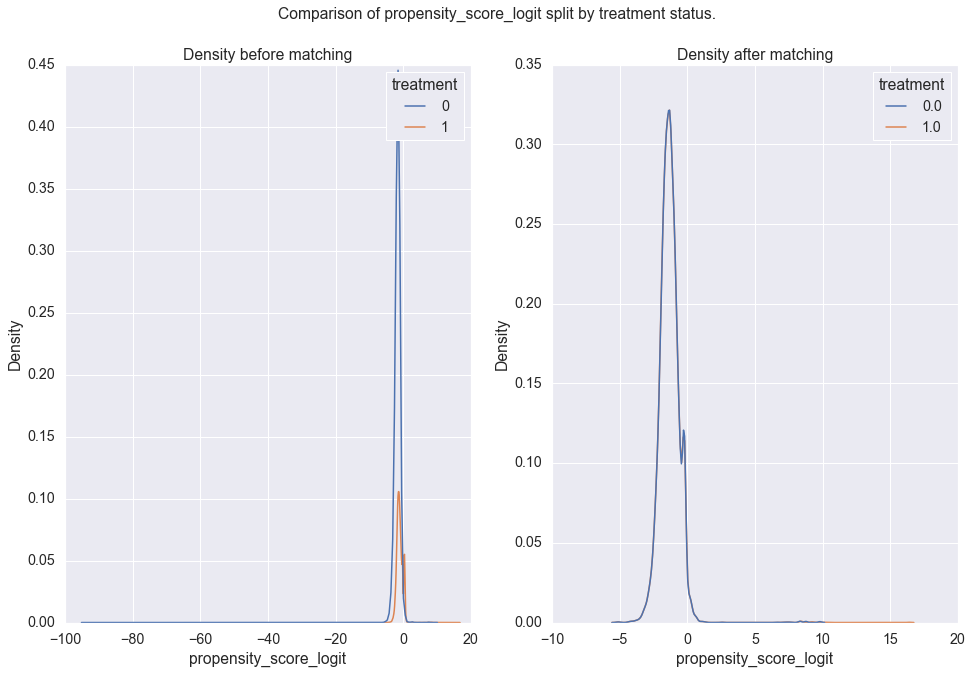

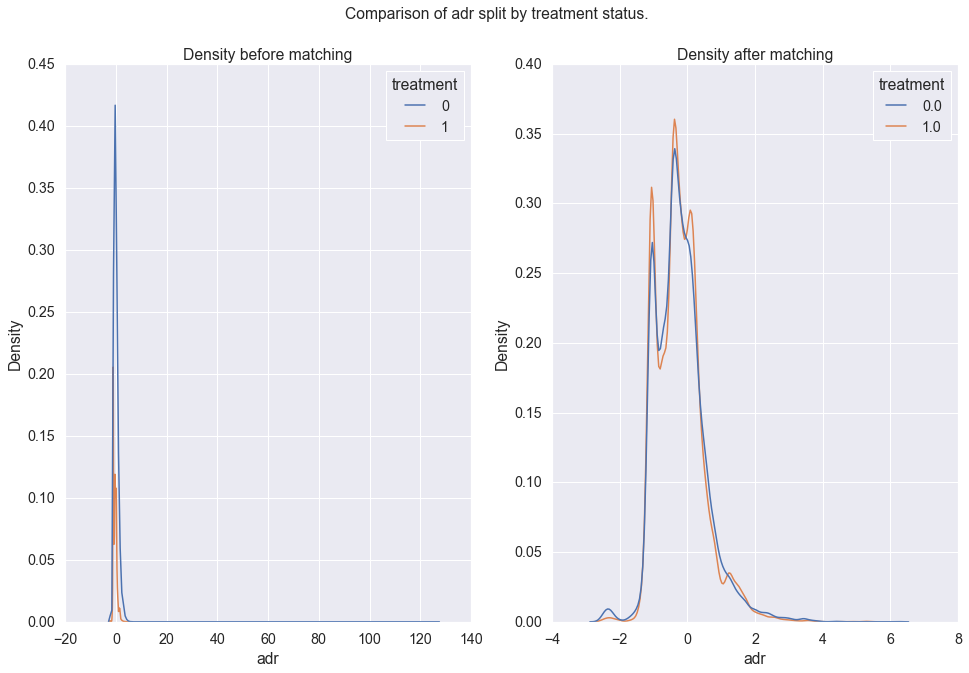

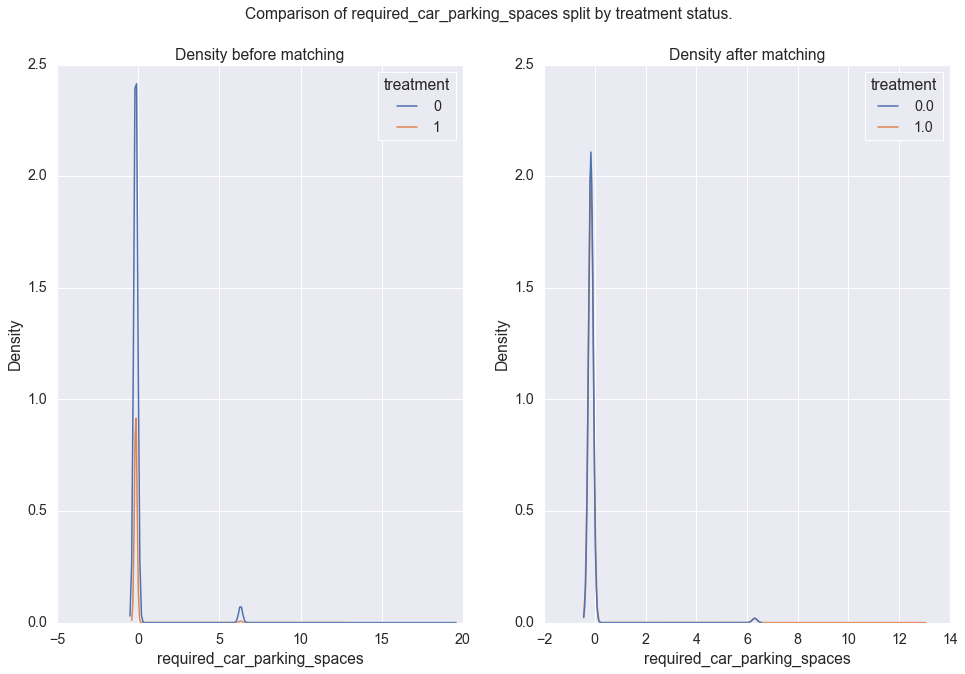

In [231]:
args = ['propensity_score_logit','adr','required_car_parking_spaces']
all_in = all_mached_data.reset_index(drop=True)
def plot(arg):
    fig, ax = plt.subplots(1,2)
    fig.suptitle('Comparison of {} split by treatment status.'.format(arg))
    sns.kdeplot(data = df_data, x = arg, hue = 'treatment', ax = ax[0]).set(title='Density before matching')
    sns.kdeplot(data = all_in, x = arg, hue = 'treatment',  ax = ax[1]).set(title='Density after matching')
    plt.show()
    fig.savefig("{}_comparison.png".format(arg))

for arg in args:
    plot(arg)

In [232]:
num_df.columns

Index(['lead_time', 'previous_cancellations', 'booking_changes', 'adr',
       'required_car_parking_spaces', 'total_customer'],
      dtype='object')

In [233]:
df_data[df_data.columns[:-5]] = df_data[df_data.columns[:-5]].astype('float')
all_in[all_in.columns[:-5]]=all_in[all_in.columns[:-5]].astype('float')

def compute_smd(data, control_cols,treatment, title=""):
    df=data.copy()
    smd = pd.DataFrame(columns = ["control_variable","smd"])
    b = pd.DataFrame(columns = ["control_variable","b"])
    
    for control in control_cols:
        #bias
        B=np.mean(df.loc[df['treatment']==1, control])-np.mean(df.loc[df['treatment']==0, control])
        if control in num_df.columns:
            SB= np.sqrt((np.var(df.loc[df['treatment']==1,control]) + np.var(df.loc[df['treatment']==0,control]))/2)
        else:
            p1_xk = np.sum(df.loc[df['treatment']==1, control])/len(df.loc[df['treatment']==1])
            p0_xk = np.sum(df.loc[df['treatment']==1, control])/len(df.loc[df['treatment']==0])
    
            SB = np.sqrt((p1_xk*(1-p1_xk) + p0_xk*(1-p0_xk))/2)
        smd= smd.append({"control_variable":control, "smd":B/SB},ignore_index = True)
        b= b.append({"control_variable":control , "b":B},ignore_index= True)
    smd['legend'] = title
    return smd, b
def CheckCovariateBalance(df, data_matched, control_cols, treatment_col):
    smd_before = compute_smd(df, control_cols, treatment_col, "Before")[0]
    smd_after = compute_smd(data_matched, control_cols, treatment_col, "After")[0]
    
    b_before = compute_smd(df, control_cols, treatment_col, "Before")[1]
    b_after = compute_smd(data_matched, control_cols, treatment_col, "After")[1]
    
    pbr = pd.merge(b_before,b_after, on='control_variable')
    pbr['pbr']=(pbr['b_x'] - pbr['b_y'])/pbr['b_x']
    pbr = pbr.drop(['b_x','b_y'],axis=1)
    print("pbr:")
    print(pbr)
    
    res = smd_before.append(smd_after, ignore_index=True)
    fig = go.Figure(data=[
        go.Bar(name='Before', y= smd_before['control_variable'], x=smd_before['smd'],orientation = 'h', marker_color = px.colors.qualitative.Plotly[0]),
        go.Bar(name='After', y= smd_after['control_variable'], x=smd_after['smd'],orientation = 'h', marker_color = px.colors.qualitative.Plotly[9]),
    ])
    fig.update_layout(
    title = "Covariate balance before and after matching",
    xaxis_title="Standardized Mean Difference (SMD)",
    yaxis_title="Control Variable")
    
    fig.add_vline(x=-0.05, line_dash="dash", line_color="red")
    fig.add_vline(x=0.05, line_dash="dash", line_color="red")
    fig.add_vrect(x0=-0.05, x1=0.05, line_width=0, fillcolor='red', opacity=0.1)
    
    fig.update_layout(barmode='group')
    fig.show()

In [234]:
CheckCovariateBalance(df_data, all_in, control_cols=df_data.columns[:-5], treatment_col=df_data.columns[-5])

pbr:
                        control_variable       pbr
0                       country_w-europe  1.070657
1                  market_segment_online  1.025650
2             distribution_channel_TA/TO  1.236089
3                    is_repeated_guest_1 -2.812496
4               reserved_room_type_else4  1.341549
5               assigned_room_type_else5  1.220418
6      days_in_waiting_list_on_wait_list  0.580550
7                    customer_type_else3  1.050078
8          total_of_special_requests_yes  1.130861
9   weekend_or_weekday_stay_just_weekday  0.948067
10  weekend_or_weekday_stay_just_weekend  1.116091
11     weekend_or_weekday_undefined_data  1.921311
12                             is_family  2.158025
13                previous_cancellations  0.870661
14                       booking_changes  2.152226
15                                   adr  0.965302
16           required_car_parking_spaces  1.019547
17                        total_customer  1.460534


In [240]:
import math
from scipy import stats
from scipy.stats import norm

def sensitivity_analysis(x,y):
    result = pd.DataFrame({'x':x,'y':y})
    result['diff'] = result['x']!= result['y']
    result = result.loc[result['diff']].reset_index(drop=True)
    
    statistics = stats.wilcoxon(result['x'], result['y'], correction = True)[0]
    s = len(result)
    
    params = np.arange(1,10.01,0.25).tolist()
    lam = [p/(1+p) for p in params]
    mu_min = [(1-j) * s * (s+1)/2 for j in lam]
    mu_max = [j * s *(s+1)/2 for j in lam]
    sigma = [math.sqrt(j * (1-j) * s * (s+1) * (2*s +1)/6) for j in lam]
    
    pvalue_min = [1- stats.norm.cdf(abs((statistics - m)/s)) for m,s in zip(mu_min, sigma)]
    pvalue_max = [1- stats.norm.cdf(abs((statistics - m)/s)) for m,s in zip(mu_max, sigma)]
    
    sensitivity = pd.DataFrame({'lambda': params,
                               'pvalue_min':pvalue_min,
                               'pvalue_max':pvalue_max})
    
    sensitivity['pvalue_min'] = sensitivity['pvalue_min'].apply(lambda x: '%.5f'%x)
    sensitivity['pvalue_max'] = sensitivity['pvalue_max'].apply(lambda x: '%.5f'%x)

    return sensitivity

In [236]:
all_mached_data.shape[0]/2

12215.0

In [237]:
y_1 = []
for i in all_mached_data['matched_element'][:12215]:
    y_1.append(np.unique(all_mached_data.loc[i]['outcome']))
yy1 = []
for xs in y_1:
    for x in xs:
        yy1.append(x)

In [238]:
all_mached_data['outcome']= all_mached_data['outcome'].astype('int')
xx1 = all_mached_data['outcome'][:12215].values
xx1

array([0, 0, 1, ..., 0, 0, 0])

In [241]:
sensitivity_analysis(yy1,xx1)

,lambda,pvalue_min,pvalue_max
0,1.00,0.00000,0.00000
1,1.25,0.00000,0.00000
2,1.50,0.00000,0.00000
3,1.75,0.00000,0.00000
4,2.00,0.06973,0.00000
5,2.25,0.02501,0.00000
6,2.50,0.00000,0.00000
7,2.75,0.00000,0.00000
8,3.00,0.00000,0.00000
9,3.25,0.00000,0.00000
